# A Pseudoproxy Experiment with "pseudoPAGES2k"

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
import pandas as pd
import numpy as np

## Paleoclimate data assimilation (PDA) steps
### Create a reconstruction job object `cfr.ReconJob` and load the pseudoPAEGS2k database

(800.0, 2000.0)

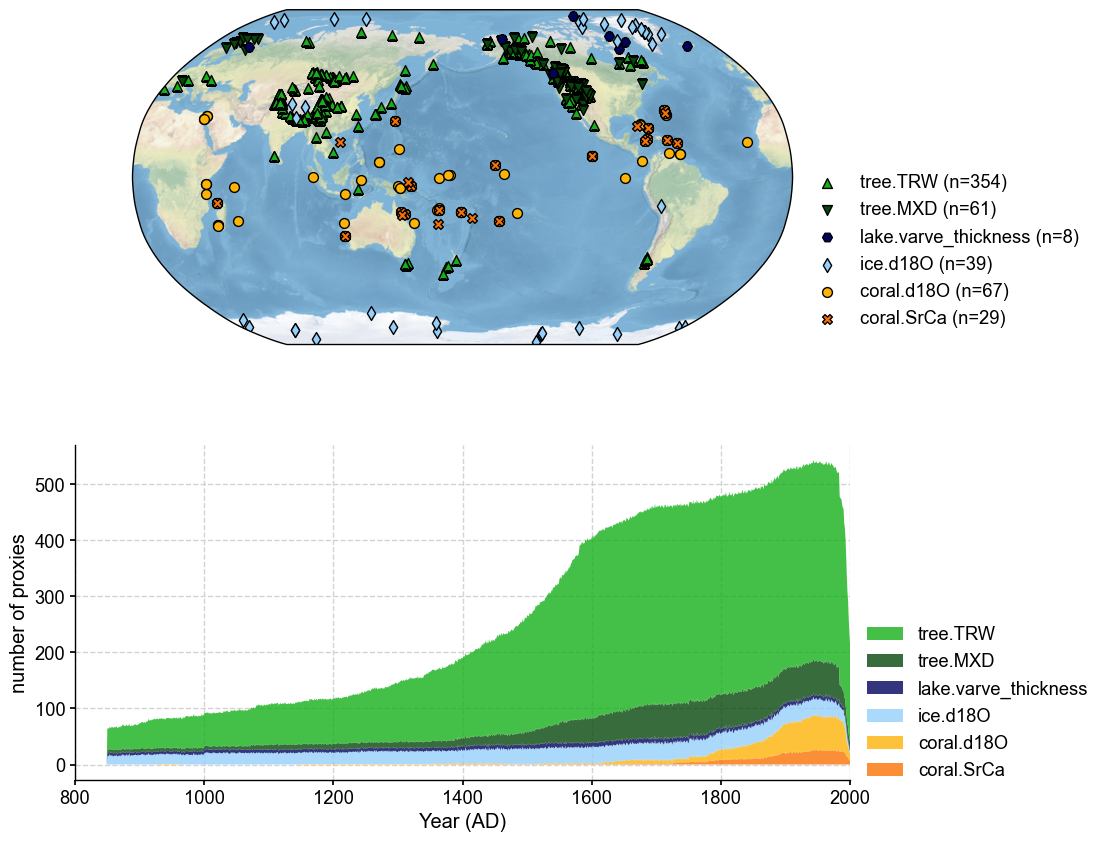

In [2]:
# create a reconstruction job object using the `cfr.ReconJob` class
job = cfr.ReconJob()

# load the pseudoPAGES2k database from a netCDF file
job.proxydb = cfr.ProxyDatabase().load_nc('./data/pp2k_nc/ppwn_SNR10_rta.nc')

# plot to have a check of the database
fig, ax = job.proxydb.plot(plot_count=True)
ax['count'].set_xlim(800, 2000)

### Load the model prior (iCESM simulated tas & pr fields) from two netCDF files

In [3]:
job.load_clim(
    tag='prior',
    path_dict={
        'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc',
        'pr': './data/pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc',
    },
    anom_period=(1951, 1980),  # calculate anomalies against the reference interval 1951-1980 CE
    verbose=True,
)

>>> job.configs["prior_path"] = {'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc', 'pr': './data/pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc'}
>>> job.configs["prior_anom_period"] = (1951, 1980)
>>> job.configs["prior_lon_name"] = lon
>>> job.configs["prior_time_name"] = time


/Users/fzhu/Github/cfr/cfr/climate.py:191: UserWarning: rename 'lat' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  new.da = self.da.rename(new_vn)
/Users/fzhu/Github/cfr/cfr/climate.py:191: UserWarning: rename 'lon' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  new.da = self.da.rename(new_vn)
/Users/fzhu/Github/cfr/cfr/climate.py:191: UserWarning: rename 'lat' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  new.da = self.da.rename(new_vn)
/Users/fzhu/Github/cfr/cfr/climate.py:191: UserWarning: rename 'lon' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  new.da = self.da.rename(new_vn)


>>> prior variables ['tas', 'pr'] loaded
>>> job.prior created


### Load the instrumental observations from two netCDF files

As a perfect model prior pseudoproxy experiment (PPE), we use the iCESM simulated fields as instrumental observations.

In [4]:
# below is a shortcut
job.obs = job.prior.copy()

# if it is not a perfect model prior experiment,
# we should use `job.load_clim()` but with `tag='obs'`
# to load the fields as instrument observations
#
# job.load_clim(
#     tag='obs',
#     path_dict={
#         'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc',
#         'pr': './data/pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc',
#     },
#     anom_period=(1951, 1980),
#     verbose=True,
# )


### Setup the proxy system models (PSMs) for different proxy types

In [5]:
# PSM type
ptype_psm_dict = {
    'tree.TRW': 'Bilinear',
    'tree.MXD': 'Linear',
    'coral.d18O': 'Linear',
    'coral.SrCa': 'Linear',
    'ice.d18O': 'Linear',
    'lake.varve_thickness': 'Linear',
}

# Seasonality for each proxy type
ptype_season_dict = {
    'tree.TRW': [  # expert curated pool of possible growing seasons
        [1,2,3,4,5,6,7,8,9,10,11,12],
        [6,7,8],
        [3,4,5,6,7,8],
        [6,7,8,9,10,11],
        [-12,1,2],
        [-9,-10,-11,-12,1,2],
        [-12,1,2,3,4,5],
    ],
    'tree.MXD': [  # expert curated pool of possible growing seasons
        [1,2,3,4,5,6,7,8,9,10,11,12],
        [6,7,8],
        [3,4,5,6,7,8],
        [6,7,8,9,10,11],
        [-12,1,2],
        [-9,-10,-11,-12,1,2],
        [-12,1,2,3,4,5],
    ],
    'coral.d18O': list(range(1, 13)),            # annual
    'coral.SrCa': list(range(1, 13)),            # annual
    'ice.d18O': list(range(1, 13)),              # annual
    'lake.varve_thickness': list(range(1, 13)),  # annual
}

### Calibrate the PSMs

Since the seasonality for TRW and MXD is undetermined, it can take a while to search for the optimal growing season for each site of TRW and MXD.

Note that PMSs cannot be calibrated at some sites due to the limited available data points over the instrumental period. These sites will be skipped for data assimilation.

In [6]:
job.calib_psms(
    ptype_psm_dict=ptype_psm_dict,
    ptype_season_dict=ptype_season_dict,
    verbose=True,)

>>> job.configs["ptype_psm_dict"] = {'tree.TRW': 'Bilinear', 'tree.MXD': 'Linear', 'coral.d18O': 'Linear', 'coral.SrCa': 'Linear', 'ice.d18O': 'Linear', 'lake.varve_thickness': 'Linear'}
>>> job.configs["ptype_season_dict"] = {'tree.TRW': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [6, 7, 8], [3, 4, 5, 6, 7, 8], [6, 7, 8, 9, 10, 11], [-12, 1, 2], [-9, -10, -11, -12, 1, 2], [-12, 1, 2, 3, 4, 5]], 'tree.MXD': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [6, 7, 8], [3, 4, 5, 6, 7, 8], [6, 7, 8, 9, 10, 11], [-12, 1, 2], [-9, -10, -11, -12, 1, 2], [-12, 1, 2, 3, 4, 5]], 'coral.d18O': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'coral.SrCa': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'ice.d18O': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'lake.varve_thickness': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
>>> job.configs["psm_calib_period"] = [1850, 2015]


Calibrating the PSMs:  13%|█▎        | 72/558 [11:30<53:41,  6.63s/it]  

The number of overlapped data points is 15 < 25. Skipping ...


Calibrating the PSMs:  15%|█▍        | 83/558 [12:52<49:38,  6.27s/it]  

The number of overlapped data points is 23 < 25. Skipping ...


Calibrating the PSMs:  23%|██▎       | 128/558 [19:39<56:38,  7.90s/it]  

The number of overlapped data points is 22 < 25. Skipping ...


Calibrating the PSMs:  24%|██▍       | 133/558 [20:33<1:00:10,  8.50s/it]

The number of overlapped data points is 19 < 25. Skipping ...


Calibrating the PSMs:  49%|████▊     | 272/558 [38:19<15:43,  3.30s/it]  

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  57%|█████▋    | 318/558 [45:29<33:05,  8.27s/it]

The number of overlapped data points is 6 < 25. Skipping ...


Calibrating the PSMs:  57%|█████▋    | 319/558 [45:30<23:23,  5.87s/it]

The number of overlapped data points is 14 < 25. Skipping ...


Calibrating the PSMs:  58%|█████▊    | 321/558 [45:59<33:57,  8.60s/it]


KeyboardInterrupt: 

### Run the PSMs

In [ ]:
job.forward_psms(verbose=True)

Forwarding the PSMs: 100%|██████████| 547/547 [02:20<00:00,  3.91it/s]

>>> ProxyRecord.pseudo created for 547 records


### Annualize the model prior fields

This step will determine the temporal resolution of the reconstructed fields.

In [ ]:
job.annualize_clim(tag='prior', verbose=True, months=list(range(1, 13)))

>>> job.configs["prior_annualize_months"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
>>> Processing tas ...
>>> Processing pr ...
>>> job.prior updated


### Regrid the model prior fields

This step will determine the spatial resolution of the reconstructed fields.

In [ ]:
job.regrid_clim(tag='prior', nlat=42, nlon=63, verbose=True)

>>> job.configs["prior_regrid_nlat"] = 42
>>> job.configs["prior_regrid_nlon"] = 63
>>> Processing tas ...
>>> Processing pr ...


### Run the DA solver with Monte-Carlo iterations

In [ ]:
job.run_da_mc(
    save_dirpath='./results/lmr-ppe-pages2k',
    recon_seeds=list(range(1, 3)),  # as an example here; normally set range(1, 21)
    recon_vars=['tas', 'pr'],  # to reconstruct both the tas and pr fields
    recon_period=[850, 2000],
    compress_params={'zlib': True, 'least_significant_digit': 5},  # pr requires more significant digits
    verbose=True,
)

>>> job.configs["recon_period"] = [850, 2000]
>>> job.configs["recon_vars"] = ['tas', 'pr']
>>> job.configs["recon_seeds"] = [1, 2]
>>> job.configs["save_dirpath"] = ./results/lmr-ppe-pages2k
>>> job.configs["compress_params"] = {'zlib': True, 'least_significant_digit': 5}
>>> seed: 1 | max: 2


KF updating:  98%|█████████▊| 1127/1151 [3:22:24<04:18, 10.78s/it]    


KeyboardInterrupt: 

## Validation steps

### Create the reconstruction result object `cfr.ReconRes`

In [35]:
res = cfr.ReconRes('./results/lmr-ppe-pages2k', verbose=True)

>>> res.paths:
['./results/lmr-ppe-pages2k/job_r01_recon.nc']


### Load the reconstructed variables

Here we validate `tas` and NINO3.4 index as an example.
We will load the `pr` fields anyway only to have a check.

In [36]:
res.load(['tas', 'pr', 'nino3.4'], verbose=True)

>>> ReconRes.recons["tas"] created
>>> ReconRes.da["tas"] created
>>> ReconRes.recons["pr"] created
>>> ReconRes.da["pr"] created
>>> ReconRes.recons["nino3.4"] created
>>> ReconRes.da["nino3.4"] created


We calculate the annualized NINO3.4 from the "instrumental observations" as a reference for validation.

In [13]:
da = job.obs['tas'].annualize().da
da = cfr.utils.geo_mean(da, lat_min=-5, lat_max=5, lon_min=np.mod(-170, 360), lon_max=np.mod(-120, 360))
ref_time = [t for t in da.year]
ref_value = da.values
ref_name = 'truth'

### Validate the reconstructed NINO3.4

We first validate the reconstructed NINO3.4 index.
Note that here we have used a chain calling of several methods, including the validation step `.validate()` and the plotting step `.plot_qs()`.

(800.0, 2000.0)

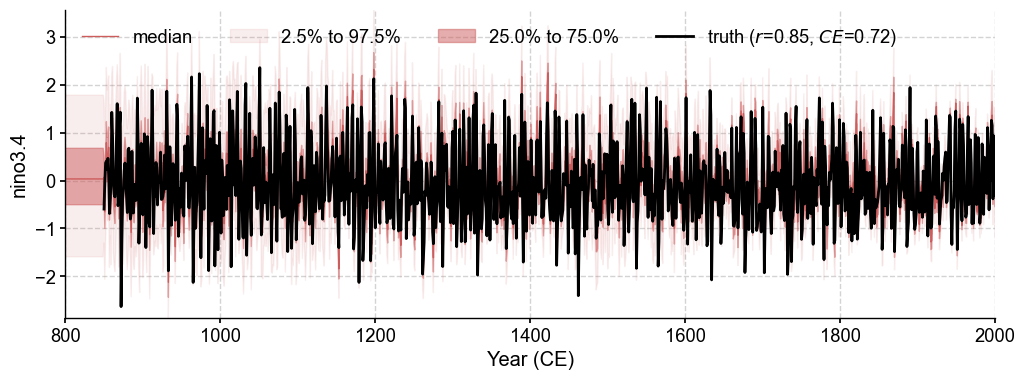

In [14]:
fig, ax = res.recons['nino3.4'].validate(ref_time, ref_value, ref_name).plot_qs()
ax.set_xlim(800, 2000)

### Validate the reconstructed fields (tas & pr)

In [15]:
# Preparations to add markers representing the sites on the map

lats, lons, colors, markers, markersizes = {}, {}, {}, {}, {}
for pid, pobj in job.proxydb.filter(by='tag', keys=['calibrated']).records.items():
    lats[pid] = pobj.lat
    lons[pid] = pobj.lon
    colors[pid] = cfr.visual.STYLE.colors_dict[pobj.ptype]
    markers[pid] = cfr.visual.STYLE.markers_dict[pobj.ptype]
    markersizes[pid] = 50

Calculate and visualize the coefficient of determination ($R^2$) between reconstructed and true tas fields.

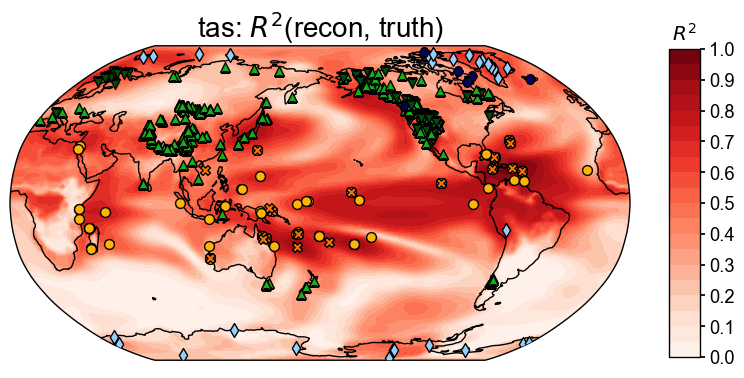

In [20]:
stat = 'R2'
valid_fd = res.recons['tas'].validate(
    job.obs['tas'].annualize(), stat=stat,
    valid_period=(1750, 1850),
    interp_direction='to-ref',
)
fig, ax = valid_fd.plot(
    title=fr'tas: $R^2$(recon, truth)',
    # projection='PlateCarree',
    # latlon_range=(-18, 18, 152, 248),
    add_cyclic_point=True,
    site_lats=lats, site_lons=lons,
    site_markersize=markersizes, site_marker=markers,
    site_color=colors, cbar_title_y=1,
    **valid_fd.plot_kwargs)

Calculate and visualize the coefficient of determination ($R^2$) between reconstructed and true pr fields.

/Users/fzhu/Apps/miniconda3/envs/cfr-env-py310/lib/python3.10/site-packages/matplotlib/contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/fzhu/Apps/miniconda3/envs/cfr-env-py310/lib/python3.10/site-packages/matplotlib/contour.py:1492: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


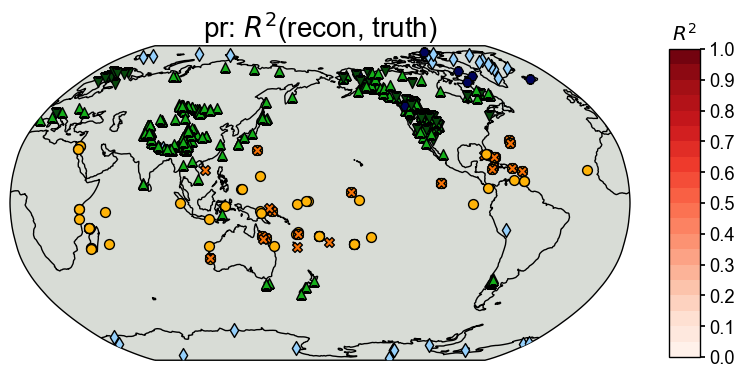

In [21]:
stat = 'R2'
valid_fd = res.recons['pr'].validate(
    job.obs['pr'].annualize(), stat=stat,
    valid_period=(1750, 1850),
    interp_direction='to-ref',
)
fig, ax = valid_fd.plot(
    title=fr'pr: $R^2$(recon, truth)',
    # projection='PlateCarree',
    # latlon_range=(-18, 18, 152, 248),
    add_cyclic_point=True,
    site_lats=lats, site_lons=lons,
    site_markersize=markersizes, site_marker=markers,
    site_color=colors, cbar_title_y=1,
    **valid_fd.plot_kwargs)